### Empirical Example Four for RobustiPy!

#### This example is designed to show how the OLSRobust class can be used to estimate a model with longitudinal data _and_ a set of specific, constant x-variables.

Specifically, it represents an Adult Social Care (ASC) example from Zhang, Bennett and Yeandle published in the BMJ Open. You can find that paper [here](https://bmjopen.bmj.com/content/11/12/e049652). Unfortunately, because of the way that it links UKHLS data to ASC spending, we are unable to make that dataset publicly available. This notebook, however, should give you an example of how it works.

A discussion question: how close are the estimates from RobustiPy to their results for the coefficient on LA ASC Spending in Table AI, for example?

First, lets load in the libraries we might need, as always:

In [1]:
import os
from robustipy.utils import prepare_union, prepare_asc
import matplotlib.pyplot as plt
from robustipy.models import OLSRobust

Now, call the helper function in the `robustipy.utils` module (Note: this is subject to change!). We have again put data at somewhere like `./data/input/`, similar to the other examples.

In [2]:
y, c, x, g, data = prepare_asc(os.path.join('data',
                                            'input',
                                            'CleanData_LASpending.dta'))

Importantly, we want our 'grouping' variable for the longitudinal analysis to be a 'string variable':

In [3]:
data[g] = data[g].astype(str)

Lets see what we have in this dataset as a result of the `prepare_asc()` function:

In [4]:
data.columns

Index([  'wellbeing_kikert',            'lrealgs', 'dcareNew*c.lrealgs',
                 'dcareNew',                 'DR',               'lgva',
                    'Mtotp',             'ddgree',                'age',
                     2005.0,               2006.0,               2007.0,
                     2009.0,               2010.0,               2011.0,
                     2012.0,               2013.0,               2014.0,
                     2015.0,               2016.0,               2017.0,
                     2018.0,            'married',            'widowed',
                  'disable',        'lrealtinc_m',    'house_ownership',
                   'hhsize',               'work',            'retired',
                     'pidp'],
      dtype='object')

OK, so clearly a lot of variables here. Lets make sure that our time fixed effects are integers, as opposed to floats. Why do we not have a year for 2008?

In [5]:
for year in range(2005, 2019):
    if year!= 2008:
        data[float(year)] = data[float(year)].astype(int)
data.columns = data.columns.astype(str)

In [6]:
for i in range(len(x)):
    try:
        # Attempt to convert to integer
        x[i] = float(x[i])
        x[i] = str(x[i])
    except ValueError:
        # If invalid for int conversion, just store its string representation
        x[i] = str(x[i])
data['pidp'] = data['pidp'].astype(int)
print(x)

['lrealgs', 'dcareNew*c.lrealgs', 'dcareNew', 'DR', 'lgva', 'Mtotp', 'ddgree', 'age', '2005.0', '2006.0', '2007.0', '2009.0', '2010.0', '2011.0', '2012.0', '2013.0', '2014.0', '2015.0', '2016.0', '2017.0', '2018.0']


Lets now eyeball our data in two important ways. First, by taking the 'head' of it:

In [7]:
data.head(5)

,wellbeing_kikert,lrealgs,dcareNew*c.lrealgs,dcareNew,DR,lgva,Mtotp,ddgree,age,2005.0,...,2018.0,married,widowed,disable,lrealtinc_m,house_ownership,hhsize,work,retired,pidp
0,6.0,11.475444,0.000000,0.0,0.580409,8.547691,0.306171,0.0,53.0,0,...,0,0.0,0.0,0.0,6.947987,0.0,2,1.0,0.0,544608605
1,11.0,12.017206,0.000000,0.0,0.589392,9.062510,0.484650,1.0,58.0,0,...,0,0.0,0.0,0.0,8.124743,1.0,1,1.0,0.0,340862245
2,12.0,10.861205,0.000000,0.0,0.602811,7.963520,0.158542,0.0,56.0,0,...,0,1.0,0.0,0.0,5.979202,1.0,2,1.0,0.0,748912565
3,10.0,11.302839,11.302839,1.0,0.567938,8.274160,0.193195,1.0,71.0,0,...,0,1.0,0.0,0.0,8.367115,1.0,2,1.0,0.0,748926165
4,7.0,12.484859,0.000000,0.0,0.505666,10.017715,0.723042,1.0,26.0,0,...,0,0.0,0.0,0.0,8.006728,1.0,2,1.0,0.0,410088289


Then, by looking at the correlation matrix of it:

In [8]:
data.corr()

,wellbeing_kikert,lrealgs,dcareNew*c.lrealgs,dcareNew,DR,lgva,Mtotp,ddgree,age,2005.0,...,2018.0,married,widowed,disable,lrealtinc_m,house_ownership,hhsize,work,retired,pidp
wellbeing_kikert,1.000000,0.021962,0.056423,0.056078,-0.007103,0.005124,0.018190,-0.045369,-0.007697,0.002999,...,0.003674,-0.059293,0.009764,0.218854,-0.062148,-0.096179,-0.010190,-0.116511,-0.039451,0.000879
lrealgs,0.021962,1.000000,0.031893,0.011635,-0.032193,0.676267,0.902588,-0.002263,-0.025727,-0.005191,...,0.010175,-0.002466,0.004284,0.013158,-0.033330,-0.033724,0.034348,-0.032636,-0.007989,0.006766
dcareNew*c.lrealgs,0.056423,0.031893,1.000000,0.998871,0.035267,-0.001630,0.033313,-0.057484,0.103288,-0.011956,...,0.003925,0.020580,-0.032895,0.073241,-0.026760,0.022502,0.018442,-0.066099,0.046951,0.010321
dcareNew,0.056078,0.011635,0.998871,1.000000,0.035652,-0.015768,0.014199,-0.057258,0.104079,-0.011756,...,0.003511,0.020604,-0.032961,0.073060,-0.025949,0.022724,0.017098,-0.065359,0.047280,0.010270
DR,-0.007103,-0.032193,0.035267,0.035652,1.000000,-0.354133,0.077159,-0.129858,0.132497,-0.011544,...,0.003593,-0.009458,0.039089,0.059941,-0.026343,0.206570,-0.047370,-0.029806,0.113675,0.009605
lgva,0.005124,0.676267,-0.001630,-0.015768,-0.354133,1.000000,0.673414,0.058118,-0.061982,-0.015341,...,0.012770,0.015633,-0.017872,-0.025304,-0.002652,-0.099659,0.058518,0.000189,-0.043643,0.044408
Mtotp,0.018190,0.902588,0.033313,0.014199,0.077159,0.673414,1.000000,-0.010985,-0.015584,-0.020336,...,0.014384,0.007528,0.001398,0.009953,-0.033695,0.002914,0.054406,-0.027486,-0.004977,0.039416
ddgree,-0.045369,-0.002263,-0.057484,-0.057258,-0.129858,0.058118,-0.010985,1.000000,-0.121765,-0.037528,...,0.004021,0.102342,-0.090156,-0.097317,0.239181,0.080516,-0.002794,0.221080,-0.135265,0.038600
age,-0.007697,-0.025727,0.103288,0.104079,0.132497,-0.061982,-0.015584,-0.121765,1.000000,-0.014232,...,-0.001749,-0.264488,0.363460,0.330236,0.080734,0.212149,-0.410449,-0.332712,0.717308,-0.005464
2005.0,0.002999,-0.005191,-0.011956,-0.011756,-0.011544,-0.015341,-0.020336,-0.037528,-0.014232,1.000000,...,-0.002535,-0.080980,0.007546,-0.077637,-0.010880,0.027078,-0.013557,0.014420,-0.008866,-0.137190


Lets refresh a bit our memory of what y, x, c, and now g are:

In [9]:
print(y)
print(x)
print(c)
print(g)
print(data.columns)

wellbeing_kikert
['lrealgs', 'dcareNew*c.lrealgs', 'dcareNew', 'DR', 'lgva', 'Mtotp', 'ddgree', 'age', '2005.0', '2006.0', '2007.0', '2009.0', '2010.0', '2011.0', '2012.0', '2013.0', '2014.0', '2015.0', '2016.0', '2017.0', '2018.0']
['married', 'widowed', 'disable', 'lrealtinc_m', 'house_ownership', 'hhsize', 'work', 'retired']
pidp
Index(['wellbeing_kikert', 'lrealgs', 'dcareNew*c.lrealgs', 'dcareNew', 'DR',
       'lgva', 'Mtotp', 'ddgree', 'age', '2005.0', '2006.0', '2007.0',
       '2009.0', '2010.0', '2011.0', '2012.0', '2013.0', '2014.0', '2015.0',
       '2016.0', '2017.0', '2018.0', 'married', 'widowed', 'disable',
       'lrealtinc_m', 'house_ownership', 'hhsize', 'work', 'retired', 'pidp'],
      dtype='object')


That's right! They're strings and lists! Now, lets call our OLSRobust model, just like before. Note, we don't specify the important parametres for our 'fitting' yet, and that's the bit that takes the most computational time, next up. What is different about our 'x' here, to the things that we've seen before?

In [10]:
myrobust_panel = OLSRobust(y=[y], x=x, data=data.reset_index())

Next, actually fit the model:

In [11]:
myrobust_panel.fit(controls=c,
                   draws=500,
                   kfold=10,
                   seed=192735,
                   group=g)

Output()

And then, grab our results from it:

In [12]:
asc_results = myrobust_panel.get_results()

Lets do some hopefully by now familiar things with it. First, lets have a look at the `summary_df` object, to check that everything feels right:

In [13]:
asc_results.summary_df

,median,max,min,ci_up,ci_down,r2,ll,aic,bic,hqic,av_k_metric,spec_name,y
0,0.227125,0.314256,0.126313,0.283622,0.160576,0.000568,-292327.549268,805031.098535,584910.517288,584762.980459,0.000124,(),wellbeing_kikert
1,0.215770,0.303559,0.091678,0.275626,0.143337,0.000794,-292314.599942,805005.199885,584896.228580,584741.985532,0.000319,(married),wellbeing_kikert
2,0.222876,0.319935,0.103099,0.286842,0.150360,0.000674,-292321.205566,805018.411132,584909.439828,584755.196780,0.000196,(widowed),wellbeing_kikert
3,0.209628,0.322110,0.099804,0.274128,0.148005,0.004510,-292109.337573,804594.675147,584485.703842,584331.460795,0.004063,(disable),wellbeing_kikert
4,0.226261,0.351873,0.124757,0.293766,0.155279,0.001246,-292289.650750,804955.301500,584846.330195,584692.087148,0.000765,(lrealtinc_m),wellbeing_kikert
...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.181703,0.268672,0.059266,0.246398,0.115314,0.009090,-291852.268304,804080.536607,584041.224962,583846.744598,0.008434,"(disable, married, retired, work, widowed, hhs...",wellbeing_kikert
252,0.195473,0.289338,0.048976,0.259828,0.131167,0.005426,-292055.576689,804487.153378,584447.841733,584253.361369,0.004761,"(lrealtinc_m, married, retired, work, widowed,...",wellbeing_kikert
253,0.184069,0.286392,0.072442,0.249179,0.117386,0.009130,-291850.012016,804076.024031,584036.712387,583842.232022,0.008511,"(disable, lrealtinc_m, married, retired, work,...",wellbeing_kikert
254,0.185207,0.263604,0.100757,0.239236,0.118322,0.009075,-291853.094570,804082.189141,584042.877496,583848.397131,0.008455,"(disable, lrealtinc_m, retired, work, widowed,...",wellbeing_kikert


Then, lets plot the results from it:

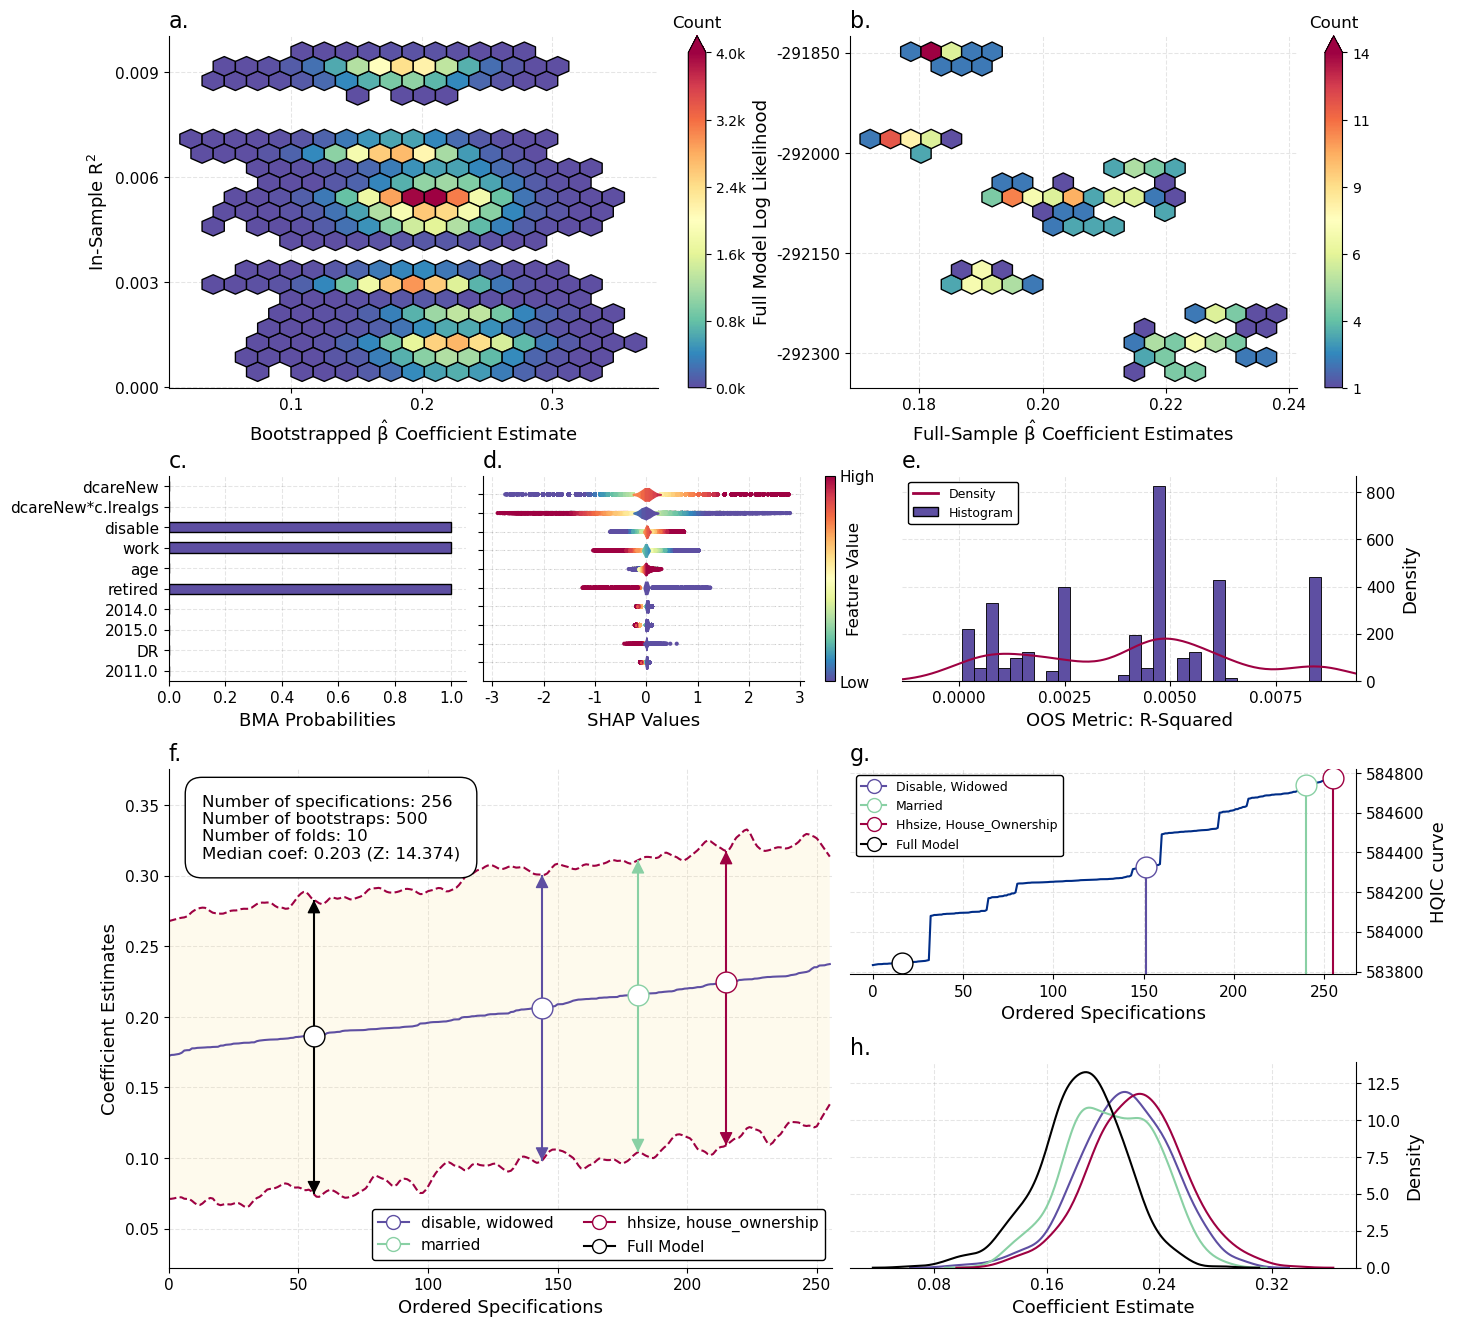

In [14]:
asc_results.plot(
    specs=[['married'],
           ['widowed', 'disable'],
           ['house_ownership', 'hhsize']
          ],
    ic='hqic',
    ext='pdf',
    project_name='asc_example',
    figsize=(16, 16)
)

Finally, lets print out our logging, to get even more information:

In [15]:
asc_results.summary()

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: wellbeing_kikert
Independent variable: lrealgs
Number of possible controls: 8
Number of draws: 500
Number of folds: 10
Number of specifications: 256
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specs, no resampling): 0.202 (p-value: 0.000)
Median beta (all specs, resampling): 0.203
Min beta (all specs, no resampling): 0.172
Min beta (all secs, resampling): 0.023
Max beta (all specs, no resampling): 0.238
Max beta (all specs, resampling): 0.130
Sig. portion of beta (all specs, no resampling): 0.000 (p-value: 0.000)
Sig. portion of beta (all specs, resampling): 0.001
Positive portion of beta (all specs, no resampling): 1.000 (p-value: 0.000)
Positive portion of beta (all specs, resampling): 1.000
Negative portion of beta (all specs, no resampling): 0.000 (p-value: 1.000)
Negative portion of beta (all specs, resampling): 0.000
Positive and sig. portion of beta (all specs, no resampling): 0.000